## Chat myPDF : RAG with LangChain, Ollama, and FAISS Vector Store

RAG PDF Dataset: https://github.com/laxmimerit/rag-dataset

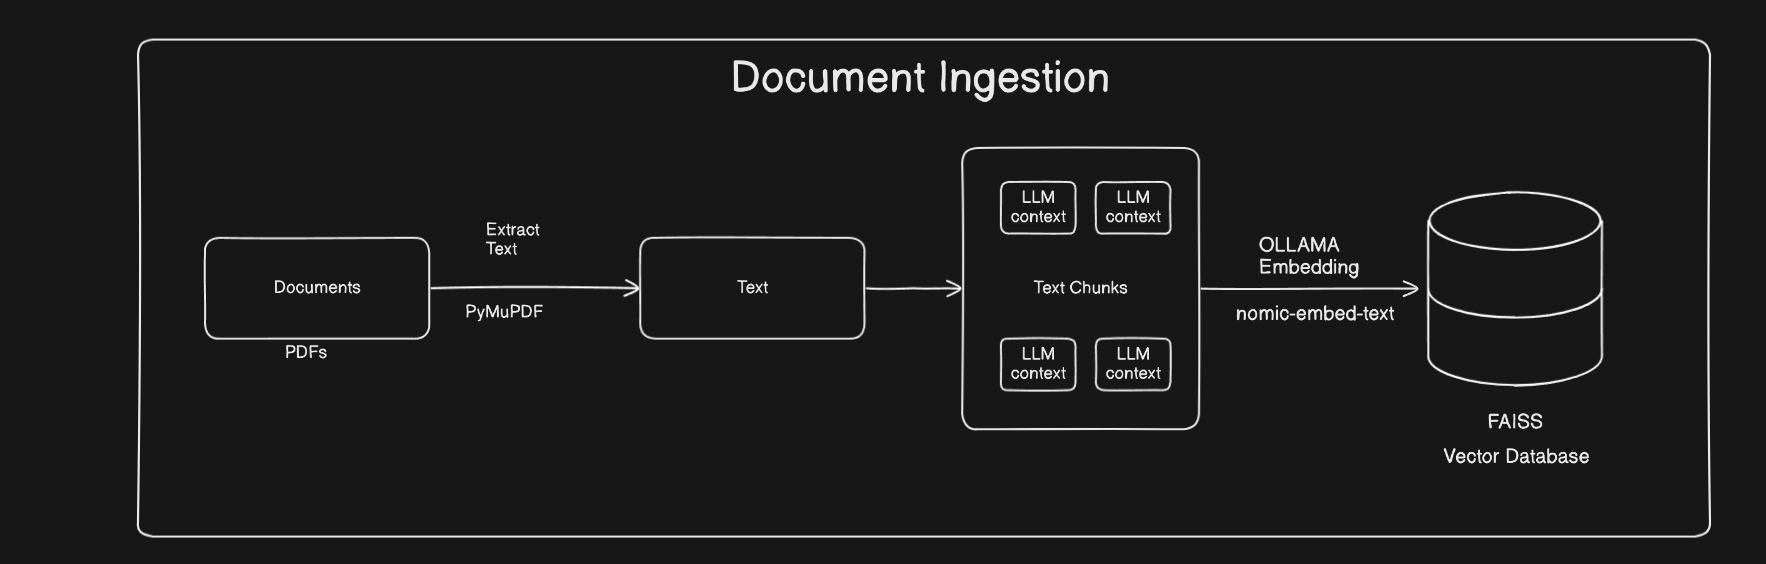

In [ ]:
# pip install -U langchain-community faiss-cpu langchain-huggingface pymupdf tiktoken langchain-ollama python-dotenv

In [1]:
import os
import warnings
from dotenv import load_dotenv

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings("ignore")

load_dotenv()

True

### Document Loader

In [10]:
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader("./rag-dataset/gym supplements/1. Analysis of Actual Fitness Supplement.pdf")

docs = loader.load()

In [11]:
doc = docs[0]
# print(doc.page_content)

In [18]:
import os

pdfs = []
for root, dirs, files in os.walk('rag-dataset'):
    # print(root, dirs, files)
    for file in files:
        if file.endswith('.pdf'):
            pdfs.append(os.path.join(root, file))

In [20]:
docs = []
for pdf in pdfs:
    loader = PyMuPDFLoader(pdf)
    pages = loader.load()

    docs.extend(pages)

In [22]:
len(docs)

64

### Document Chunking

In [23]:
from langchain_text_splitters import RecursiveCharacterTextSplitter


text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

chunks = text_splitter.split_documents(docs)

In [24]:
len(docs), len(chunks)

(64, 321)

In [32]:
len(docs[0].page_content), len(chunks[0].page_content)

(4340, 981)

In [34]:
import tiktoken

encoding = tiktoken.encoding_for_model("gpt-4o-mini")

len(encoding.encode(docs[0].page_content)), len(encoding.encode(chunks[0].page_content))

(969, 294)

### Document Vector Embedding

In [35]:
from langchain_ollama import OllamaEmbeddings

import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

In [36]:
embeddings = OllamaEmbeddings(model='nomic-embed-text', base_url="http://localhost:11434")

single_vector = embeddings.embed_query("this is some text data")


In [38]:
len(single_vector)

768

In [41]:
index = faiss.IndexFlatL2(len(single_vector))
index.ntotal, index.d

(0, 768)

In [42]:
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
)

In [46]:
len(chunks)

321

In [48]:
# help(vector_store)

In [49]:
ids = vector_store.add_documents(documents=chunks)

In [53]:
vector_store.index_to_docstore_id
len(ids)

321

In [54]:
# # store vector database
# db_name = "health_supplements"
# vector_store.save_local(db_name)

# # load vector database
# new_vector_store = FAISS.load_local(db_name, embeddings=embeddings, allow_dangerous_deserialization=True)
# len(new_vector_store.index_to_docstore_id)

321

### Retreival

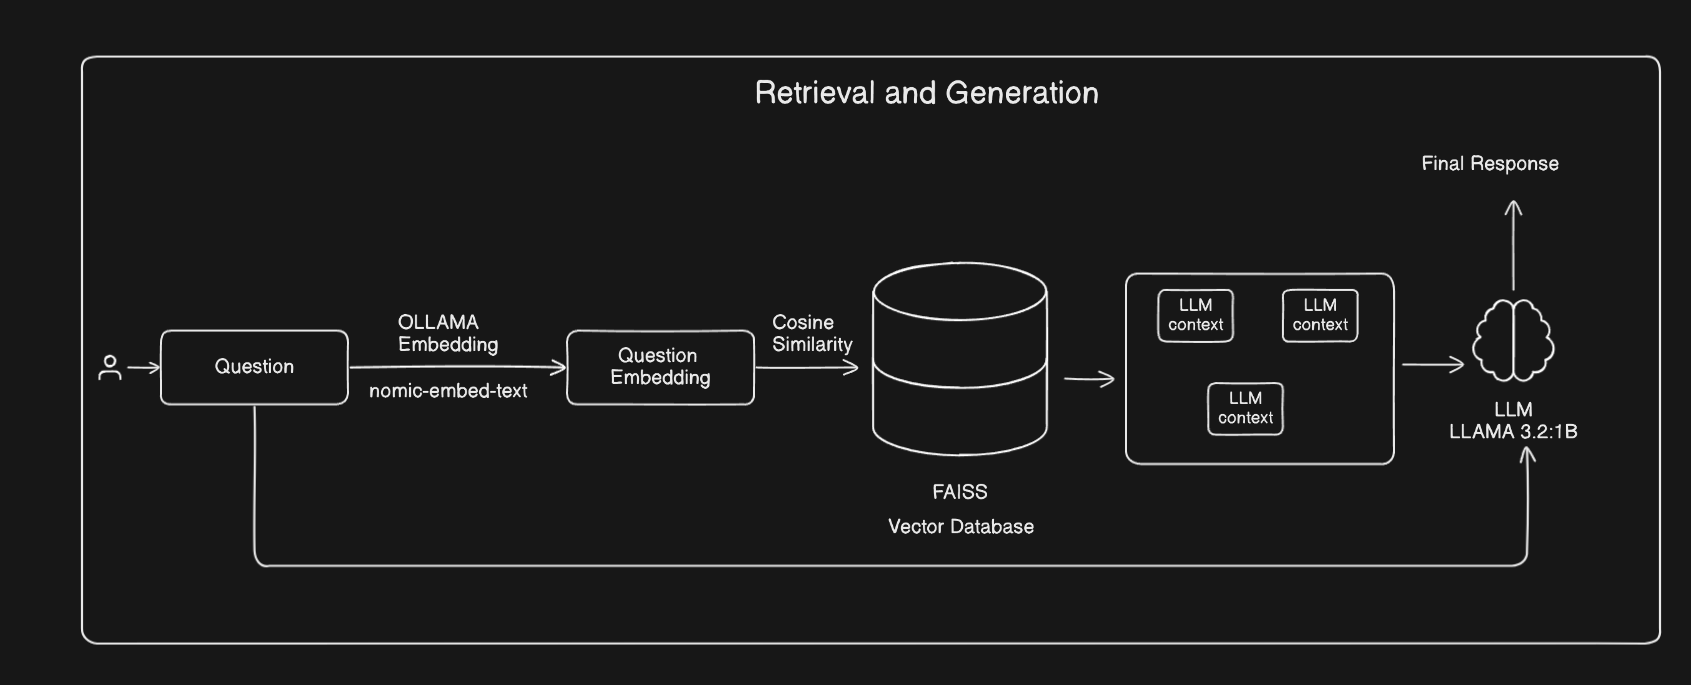

In [60]:
question = "what is used to gain muscle mass?"
docs = vector_store.search(query=question, search_type='similarity')

for doc in docs:
    print(doc.page_content)
    print("\n\n")

acids than traditional protein sources. Its numerous benefits have made it a popular choice
for snacks and drinks among consumers [3]. Another widely embraced supplement is
caffeine, which is found in many sports and food supplements. Caffeine reduces perceived
effort, minimizes fatigue and pain, and proves to be effective for endurance and high-
intensity activities, which is the choice of consumers [4].
Creatine monohydrate is another well-known supplement used to gain muscle mass
and support performance and recovery. It is known not to increase fat mass and remains
effective even when taken in recommended doses [5]. Despite its popularity in the fitness
Foods 2024, 13, 1424. https://doi.org/10.3390/foods13091424
https://www.mdpi.com/journal/foods



and strength gain among men. We detected more prevalent protein and creatine supplementation
among younger compared to older ﬁtness center users, whereas the opposite was found for vitamin
supplementation. Other authors made similar obse

In [61]:
retriever = vector_store.as_retriever(search_type="mmr", search_kwargs = {'k': 3, 
                                                                          'fetch_k': 100,
                                                                          'lambda_mult': 1})

In [ ]:
docs = retriever.invoke(question)

# for doc in docs:
#     print(doc.page_content)
#     print("\n\n")


In [66]:


question = "what is used to reduce weight?"
# question = "what are side effects of supplements?"
# question = "what are the benefits of supplements?"
# question = "what are the benefits of BCAA supplements?"
docs = retriever.invoke(question)


### RAG with LLAMA 3.2 on OLLAMA

In [67]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

from langchain_ollama import ChatOllama

In [68]:
model = ChatOllama(model="llama3.2:1b", base_url="http://localhost:11434")

model.invoke("hi")

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2024-10-22T07:25:35.7069154Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 3192992500, 'load_duration': 3042781900, 'prompt_eval_count': 26, 'prompt_eval_duration': 60138000, 'eval_count': 8, 'eval_duration': 81241000}, id='run-26d9a25a-a88d-413c-9d32-cdcbb81ee793-0', usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34})

In [69]:
prompt = hub.pull("rlm/rag-prompt")

In [81]:
prompt = """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
    If you don't know the answer, just say that you don't know.
    Answer in bullet points. Make sure your answer is relevant to the question and it is answered from the context only.
    Question: {question} 
    Context: {context} 
    Answer:
"""

prompt = ChatPromptTemplate.from_template(prompt)

In [82]:
def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

# print(format_docs(docs))

In [83]:
rag_chain = (
    {"context": retriever|format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [90]:
# question = "what is used to gain muscle mass?"
# question = "what is used to reduce weight?"
# question = "what are side effects of supplements?"
# question = "what are the benefits of supplements?"
# question = "what are the benefits of BCAA supplements?"

question = "what is used to increase mass of the Earth?"

output = rag_chain.invoke(question)
print(output)


Here are the answers to the question "what is used to increase mass of the Earth?" in bullet points:

* There is no mention of anything being used to increase the mass of the Earth. The context only discusses weight loss supplements and their potential effects on body weight.
* The text mentions that DMAA (1,3-dimethylamylamine) is a compound found in some weight-loss supplements, but it does not suggest that it has any effect on increasing the mass of the Earth.
* There is no information about anything being used to increase the mass of the Earth from the given context.


The answer is:

- Protein sources
- Caffeine
- Creatine monohydrate
